In [1]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [3]:
iowa_file_path = 'c:/users/steve/Documents/github/machine-learning/ElasticNet_IowaHousin_Kaggle/data/aimes_iowa/train.csv'
# iowa_file_path = 'D:/dDocuments/ML/Python/Kaggle/data/aimes_iowa/train.csv'
df = pd.read_csv(iowa_file_path)

#df = pd.read_csv('house_train.csv')

In [4]:
df.shape

(1460, 81)

In [5]:
#Percentage of a field that are missing
(df.isnull().sum() / len(df)).sort_values(ascending=False)[:20]

PoolQC         0.995
MiscFeature    0.963
Alley          0.938
Fence          0.808
FireplaceQu    0.473
LotFrontage    0.177
GarageYrBlt    0.055
GarageCond     0.055
GarageType     0.055
GarageFinish   0.055
GarageQual     0.055
BsmtFinType2   0.026
BsmtExposure   0.026
BsmtQual       0.025
BsmtCond       0.025
BsmtFinType1   0.025
MasVnrArea     0.005
MasVnrType     0.005
Electrical     0.001
Id             0.000
dtype: float64

In [6]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis=1, inplace=True)

In [8]:
df['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



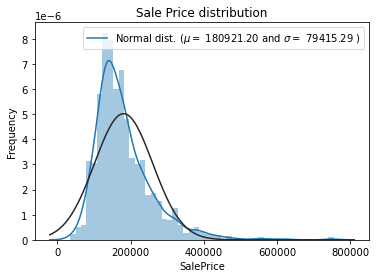

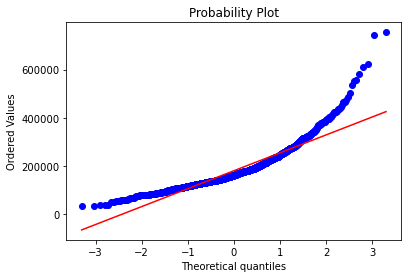

In [9]:
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show();


 mu = 12.02 and sigma = 0.40



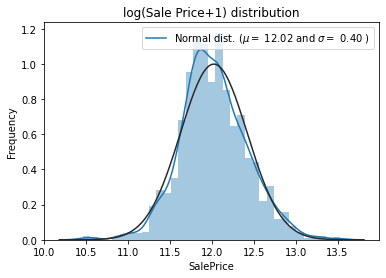

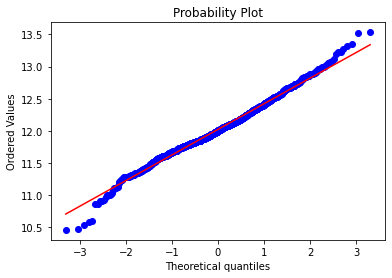

In [10]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

### Correlation between numeric features

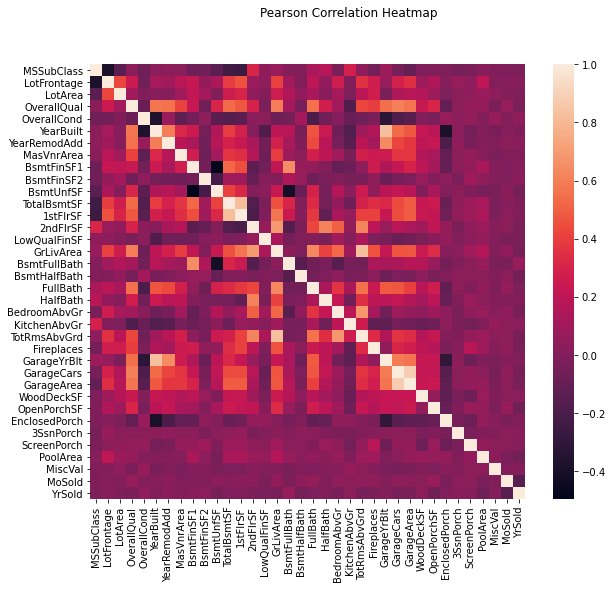

In [11]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

There exists strong correlations between some of the features. For example, GarageYrBlt and YearBuilt, TotRmsAbvGrd and GrLivArea, GarageArea and GarageCars are strongly correlated. They actually express more or less the same thing. I will let ElasticNetCV to help reduce redundancy.

### Correlation between SalePrice  and the other numeric features

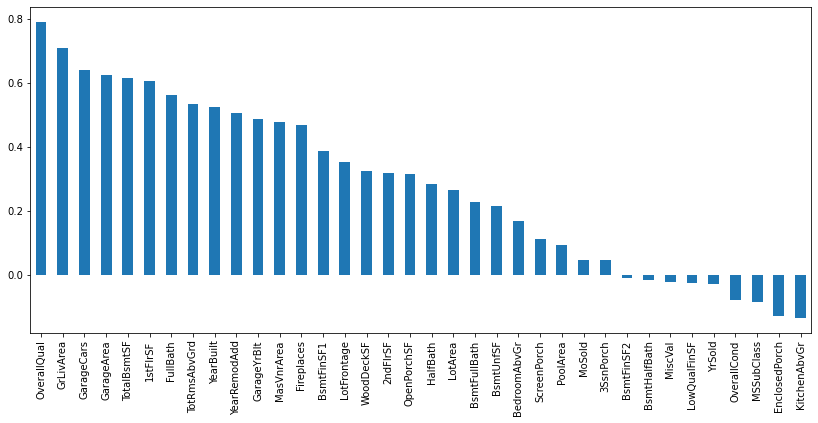

In [12]:
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();

The correlation of Sale Price with OverallQual is the greatest (around 0.8). Also GrLivArea presents a correlation of over 0.7, and GarageCars presents a correlation of over 0.6.

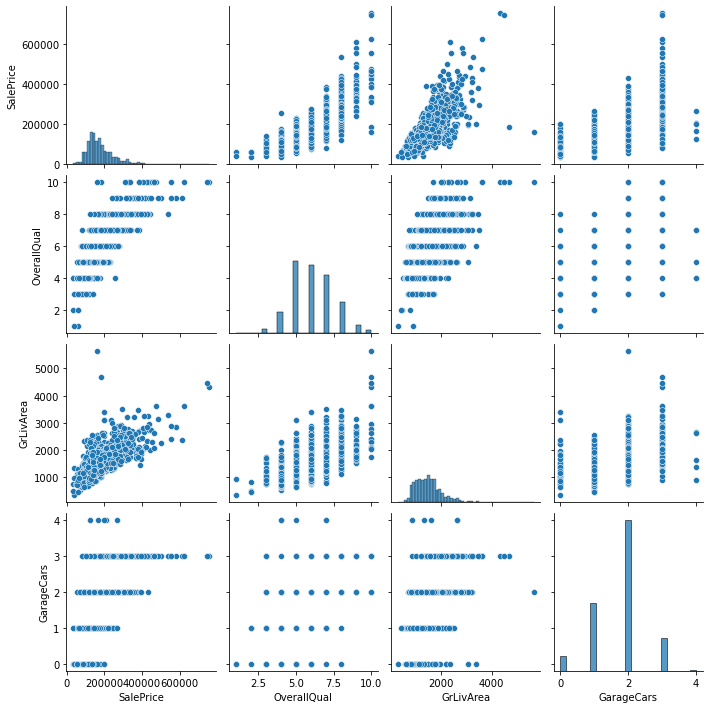

In [13]:
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])
plt.show();

Log transform the target feature and all the other skewed numerical features. 

In [14]:
df["SalePrice"] = np.log1p(df["SalePrice"])

#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])

In [15]:
df = pd.get_dummies(df)
df = df.fillna(df.mean())

In [16]:
X, y = df.drop(['SalePrice'], axis = 1), df['SalePrice']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

### ElasticNetCV

In [17]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

In [18]:
cv_model.fit(X_train, y_train)

ElasticNetCV(cv=6, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
             n_jobs=-1, normalize=True, random_state=0)

In [19]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00013634
Optimal l1_ratio: 0.700
Number of iterations 84


In [20]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.935231601879496
Test r2 score:  0.8300355301028954
Train RMSE: 0.0963
Test RMSE: 0.1604


113 features, reduction of 58.91%


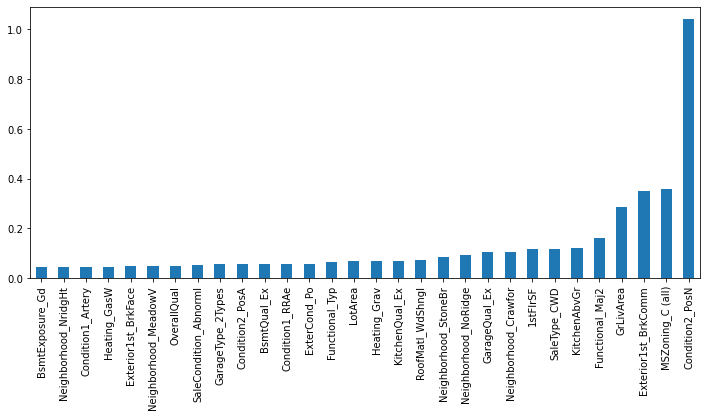

In [21]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

### Xgboost

In [22]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9995312287128847
Test r2 score:  0.879442965695563
Train RMSE: 0.0087
Test RMSE: 0.1351


In [24]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

Train r2 score:  0.9928421309247096
Test r2 score:  0.8793660770870737
Train RMSE: 0.0336
Test RMSE: 0.1351


It was an improvement!

In [25]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

Train r2 score:  0.9913698446283224
Test r2 score:  0.892895748654273
Train RMSE: 0.0367
Test RMSE: 0.1273


There was no improvement.

In [26]:
xgb_model4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

Train r2 score:  0.9867823674636849
Test r2 score:  0.8896141271373799
Train RMSE: 0.0451
Test RMSE: 0.1293


I concluded that xgb_model2 is the best model.

In [27]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 108),
             ('LotFrontage', 94),
             ('MSSubClass', 69),
             ('GrLivArea', 60),
             ('OverallQual', 56),
             ('BsmtUnfSF', 55),
             ('TotalBsmtSF', 54),
             ('1stFlrSF', 43),
             ('MoSold', 39),
             ('OverallCond', 37),
             ('BsmtFinSF1', 37),
             ('GarageArea', 36),
             ('YearBuilt', 35),
             ('YearRemodAdd', 33),
             ('OpenPorchSF', 31),
             ('WoodDeckSF', 27),
             ('MasVnrArea', 27),
             ('GarageYrBlt', 26),
             ('2ndFlrSF', 22),
             ('EnclosedPorch', 15),
             ('YrSold', 14),
             ('TotRmsAbvGrd', 14),
             ('ScreenPorch', 13),
             ('GarageCars', 12),
             ('GarageType_Attchd', 10),
             ('Fireplaces', 9),
             ('BedroomAbvGr', 9),
             ('SaleCondition_Abnorml', 9),
             ('BsmtFinSF2', 8),
             ('BsmtFullBath', 

In [28]:
most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
print(most_relevant_features)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'MSZoning_C (all)', '1stFlrSF', 'Fireplaces', 'YearRemodAdd', 'OverallCond', 'OpenPorchSF', 'LotArea', 'YearBuilt', 'BsmtFinSF1', 'LotFrontage', 'GarageType_Attchd', 'FullBath', 'GarageQual_TA', 'FireplaceQu_Po', 'BsmtUnfSF', 'BsmtFullBath', 'GarageYrBlt', 'Functional_Typ', 'KitchenAbvGr', 'MSSubClass', 'BedroomAbvGr', 'GarageArea', 'MoSold', 'Condition1_Norm', 'SaleCondition_Abnorml', 'WoodDeckSF', 'EnclosedPorch', 'BsmtExposure_Gd', 'Neighborhood_Edwards', 'SaleType_COD', 'Condition1_Artery', 'Neighborhood_Crawfor', 'SaleType_New', '2ndFlrSF', 'Neighborhood_NAmes', 'MasVnrArea', 'RoofStyle_Gable', 'YrSold', 'BsmtFinType1_ALQ', 'ScreenPorch', 'BsmtFinType1_Rec', 'FireplaceQu_Gd', 'TotRmsAbvGrd', 'ExterQual_Gd', 'MasVnrType_BrkFace', 'BsmtFinSF2', 'HouseStyle_SLvl', 'LotConfig_Corner', 'HeatingQC_TA', 'GarageFinish_RFn', 'KitchenQual_Ex', 'BsmtFinType2_BLQ', 'HalfBath', 'ExterCond_Gd', 'LotConfig_Inside', 'PoolArea']


In [29]:
train_x=df[most_relevant_features]
train_y=df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [30]:
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

Train r2 score:  0.9847200049621166
Test r2 score:  0.8749401868287896
Train RMSE: 0.0487
Test RMSE: 0.1376


Another improvement.